In [28]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle
from lightgbm import LGBMClassifier


In [3]:
df = pd.read_csv('../data/creditcard.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

We see that since there are no missing values or any categorical values, we can directly move on to modelling the data which simplifies our workload significantly. First, we will run a model with all the variables and then afterwards run a model with a lower number of features that have been removed through some sort of filter (low correlation with target variable, low variance etc.).

In [5]:
x = df.drop(['Class'], axis = 1)
y = df['Class']

Since the data has been setup temporally, we can employ time-series splits to the data, using the first 80% of the data as training data and the remaining 20% of the data as test data. 

In [6]:
print(x.shape)
train_size = int(0.8 * len(x))

x_train = x.iloc[ : train_size]
print(x_train.shape)
y_train = y.iloc[:train_size]
print(y_train.shape)
x_test = x.iloc[train_size:]
print(x_test.shape)
y_test = y.iloc[train_size: ]
print(y_test.shape)

(284807, 30)
(227845, 30)
(227845,)
(56962, 30)
(56962,)


Now that we have split the data into training and test data, it is time to scale the data before moving onto modelling.

In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
lr = LogisticRegression(max_iter = 10000, class_weight = 'balanced')
val_scores = cross_val_score(lr, x_train_scaled, y_train, cv = 5, scoring = 'precision')
print(val_scores)
print(val_scores.mean())

[0.01741137 0.08907363 0.11022364 0.04605642 0.08066298]
0.06868560974998102


In [9]:
lr.fit(x_train_scaled, y_train)
y_pred = lr.predict(x_test_scaled)
roc_score = roc_auc_score(y_test, y_pred)
print(roc_score)

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f1_score(y_test, y_pred))

0.9389320348527197
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56887
           1       0.07      0.89      0.13        75

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962

[[56007   880]
 [    8    67]]
0.13111545988258316


## Model Performance

The model demonstrates moderate fraud detection capability but suffers from a significant precision problem. With a recall of 89.3%, the model successfully identifies most fraudulent transactions, catching 67 out of 75 fraud cases. However, the precision of only 7% indicates that the model generates an excessive number of false positives—flagging 880 legitimate transactions as fraudulent.

This imbalance results in a low F1-score of 0.13, suggesting the model is currently not production-ready. While the high recall is desirable for minimizing financial losses from missed fraud, the poor precision would lead to poor customer experience, with many legitimate transactions incorrectly declined or flagged for review.

To improve model performance, we need to address the class imbalance more effectively through techniques such as SMOTE, adjusting classification thresholds, or exploring ensemble methods. We will first try to employ other baseline models to compare performances

In [10]:
rf = RandomForestClassifier(n_estimators = 250, max_depth = 10, class_weight = 'balanced', random_state = 42)


In [14]:
val_scores = cross_val_score(rf, x_train_scaled, y_train, cv = 3, scoring = 'roc_auc')
print(val_scores)
print(val_scores.mean())

[0.89810194 0.92318579 0.97356078]
0.9316161680160482


In [15]:
rf.fit(x_train_scaled, y_train)
y_pred = rf.predict(x_test_scaled)

roc_score = roc_auc_score(y_test, y_pred)
print(roc_score)

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f1_score(y_test, y_pred))

0.8666490879579987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.96      0.73      0.83        75

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56885     2]
 [   20    55]]
0.8333333333333334


In [16]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    random_state=42,
    subsample=0.9,                
    colsample_bytree=0.9,        
    gamma=0,
    reg_lambda=1.5,                
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]) ,  
    eval_metric='aucpr',
)



In [17]:
val_scores = cross_val_score(xgb_model, x_train_scaled, y_train, cv = 3, scoring = 'roc_auc')
print(val_scores)
print(val_scores.mean())

[0.98810549 0.93940195 0.97973609]
0.9690811738479983


In [20]:
xgb_model.fit(x_train_scaled ,y_train)
y_pred_proba = xgb_model.predict_proba(x_test)[:, 1]
y_pred = (y_pred_proba >= 0.55).astype(int)

roc_score = roc_auc_score(y_test, y_pred)
print(roc_score)

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f1_score(y_test, y_pred))

0.8665963518319945
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.87      0.73      0.80        75

    accuracy                           1.00     56962
   macro avg       0.94      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962

[[56879     8]
 [   20    55]]
0.7971014492753623


## Results

Both Random Forest (F1: 0.83) and XGBoost (F1: 0.82) perform similarly and way better than logistic regression. They're both catching about 72-75% of fraud with high precision (92-98%), but still missing ~25% of fraudulent transactions.

**Next steps:**
- Try RandomUnderSampler and SMOTE to balance classes better  
- Try out neural networks on the normal dataset, as well as the resampled dataset

In [21]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.1)

In [35]:
steps =  [('under', under), ('over', over), ('model', xgb_model)]
pipeline = Pipeline(steps=steps)

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, x_train_scaled, y_train, scoring='roc_auc', cv= 3, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.974


In [36]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56887
           1       0.05      0.85      0.09        75

    accuracy                           0.98     56962
   macro avg       0.52      0.92      0.54     56962
weighted avg       1.00      0.98      0.99     56962

[[55625  1262]
 [   11    64]]


In [25]:
rus = RandomUnderSampler(sampling_strategy=.1)
x_train_rs, y_train_rs = rus.fit_resample(x_train, y_train)

smote = SMOTE(sampling_strategy=0.5, k_neighbors=3)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_rs, y_train_rs)


xgb_model.fit(x_train_resampled, y_train_resampled)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [26]:
y_pred = xgb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56887
           1       0.05      0.85      0.09        75

    accuracy                           0.98     56962
   macro avg       0.52      0.92      0.54     56962
weighted avg       1.00      0.98      0.99     56962



In [29]:
lgb_model = LGBMClassifier(
    # Handle imbalance
    class_weight='balanced',  # or use is_unbalance=True
    
    # Prevent overfitting
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    
    # Learning parameters
    learning_rate=0.1,
    n_estimators=1000,
    
    # Regularization
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    
    # Other useful params
    subsample=0.8,  # Use 80% of data for each tree
    colsample_bytree=0.8,  # Use 80% of features for each tree
    
    # Speed and determinism
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

scores = cross_val_score(lgb_model, x_train, y_train, cv = 3, scoring = 'roc_auc')

In [30]:
print('Average scores:' ,  np.mean(scores))

Average scores: 0.9689788354355412


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.92      0.76      0.83        75

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC: 0.9874

Confusion Matrix:
[[56882     5]
 [   18    57]]


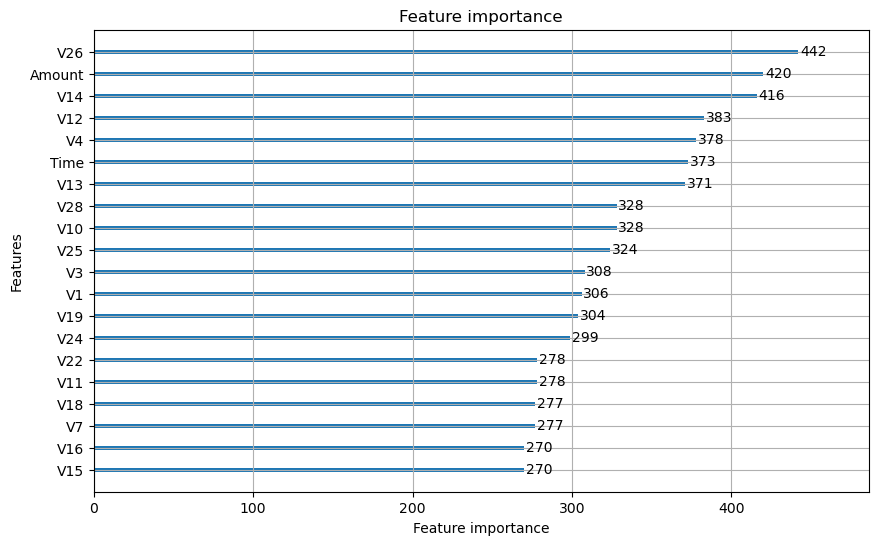

In [31]:
lgb_model.fit(x_train, y_train,)
y_pred_proba = lgb_model.predict_proba(x_test)[:, 1]
 
y_pred = lgb_model.predict(x_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(f"\nROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=20, figsize=(10, 6))
plt.show()

In [33]:
steps =  [('under', under), ('over', over), ('model', lgb_model)]
pipeline = Pipeline(steps=steps)

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv= 3, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.976


In [34]:
y_pred = xgb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56887
           1       0.05      0.85      0.09        75

    accuracy                           0.98     56962
   macro avg       0.52      0.92      0.54     56962
weighted avg       1.00      0.98      0.99     56962



In [39]:
with open('../models/lgb_model.pkl', 'wb') as f_out:
    pickle.dump(lgb_model, f_out)